In [15]:
import pandas as pd

nifty200_df = pd.read_csv('nifty200.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty200_df.Symbol.tolist()]

In [16]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data_1D = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 200/200 [00:00<00:00, 614.93it/s]


In [17]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data5m"

end_date = dt.datetime.now()
start_date = dt.datetime(2020, 1, 1)

file_paths = prepare_data(tickers, "5", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data_5m = load_stock_data(file_paths, data_path, "5")

Loading 5min data: 100%|██████████| 200/200 [00:00<00:00, 256.19it/s]


In [18]:
df = pd.concat(loaded_data_1D, names=["Stock", "Date"]).reset_index()
df = df[df.Date <= '2025-08-11 05:30:00']

df5m = pd.concat(loaded_data_5m, names=["Stock", "Date"]).reset_index()
df5m = df[df.Date <= '2025-08-11 05:30:00']

In [19]:
import talib as ta

price_band = 0.03

df.Date = pd.to_datetime(df.Date)

# Calculate RSI per stock
df['SMA5'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=5))
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA50'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=50))
df['SMA100'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=100))
df['SMA200'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=200))

df['VOL_SMA20'] = df.groupby('Stock')['Volume'].transform(lambda x: ta.SMA(x, timeperiod=20))

df['upper_threashold'] = df.Close * (1 + price_band)
df['lower_threashold'] = df.Close * (1 - price_band)

df['Entry_Price'] = df.groupby('Stock')['Close'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)
df['NxtHigh'] = df.groupby('Stock')['High'].shift(-1)
df['NxtClose'] = df.groupby('Stock')['Close'].shift(-1)

df = df[df.Date >= '2024-01-01 05:30:00']

In [20]:
signals = (
    df[
        (df.upper_threashold > df.SMA5) & (df.lower_threashold < df.SMA5) &
        (df.upper_threashold > df.SMA20) & (df.lower_threashold < df.SMA20) &
        (df.upper_threashold > df.SMA50) & (df.lower_threashold < df.SMA50) &
        (df.upper_threashold > df.SMA100) & (df.lower_threashold < df.SMA100) &
        (df.upper_threashold > df.SMA200) & (df.lower_threashold < df.SMA200) &
        (df.NxtHigh >= df.upper_threashold)
    ]
)
signals = signals.sort_values(['Date', 'VOL_SMA20'], ascending=[True, False]).groupby('Date').head(3).reset_index(drop=True)

In [21]:
signals.Date.unique().shape

(100,)

# Backtest

In [22]:
from lib import Bank, PositionManager
from tqdm.notebook import tqdm
import pandas as pd

leverage = 1
initial_capital = 500000
max_positions = 10
tp_perc = 3.14
default_bucket_capital = 50000


def book_profit(pm: PositionManager, row):
    global active_positions, closed_positions, bank
    for position in pm.get_active_positions():
        stock_data = row[row.Stock == position.stock]
        if stock_data.empty:
            continue
        stock_data = stock_data.iloc[0]
        # if stock_data.High >= positon.tp:
        #     pm.close_position(positon.stock, stock_data.Date, positon.tp)
        #     break
        if stock_data.Low <= position.sl:
            pm.close_position(position.stock, stock_data.Date, position.sl)
            return
        
        elif (position.sl < position.avg_entry_price) and (stock_data.Close - position.avg_entry_price)/position.avg_entry_price >= 0.02:
            position.sl = position.avg_entry_price * 1.01
        else:
            proposed_sl = stock_data.Close * 0.8
            if proposed_sl > position.sl:
                position.sl = proposed_sl


def backtest(pm: PositionManager):
    global active_positions, closed_positions, bank, max_positions
    pb = tqdm(total=df.Date.nunique(), desc="Backtesting...")
    for idx, row in df.groupby('Date'):
        day_signals = signals[signals.Date == idx]
        for signal in day_signals.itertuples():
            if signal.Stock in pm.get_active_positions():
                print(f"Already in position for {signal.Stock}")
                continue
            if not pm.bank.has_capital():
                pm.bank.add_capital(default_bucket_capital)
            position = pm.new_position(signal.Stock, signal.Entry_Time, signal.upper_threashold)
            if position is not None:
                position.sl = signal.lower_threashold

        book_profit(pm, row)
        pb.update(1)
    pb.close()
                
if __name__ == "__main__":
    bank = Bank(initial_capital, max_positions)
    pm = PositionManager(bank, leverage=leverage, tp_perc=tp_perc, sl_perc=100)
    backtest(pm)

Backtesting...:   0%|          | 0/402 [00:00<?, ?it/s]

invalid quantity - 0


In [23]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in pm.closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [24]:
import pandas as pd

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'CAGR (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A"
    ]
})

tearsheet

,Metric,Value
0,Period,2024-01-16 to 2025-08-11
1,Final capital,459391.78
2,Total Trades,106
3,Active Position Count,8
4,Max holding period (days),271
5,Avg holding period (days),31
6,Win Rate (%),66.98
7,Total Profit,"-40,608.22"
8,Total Tax,1984.84
9,CAGR (%),-5.26


<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

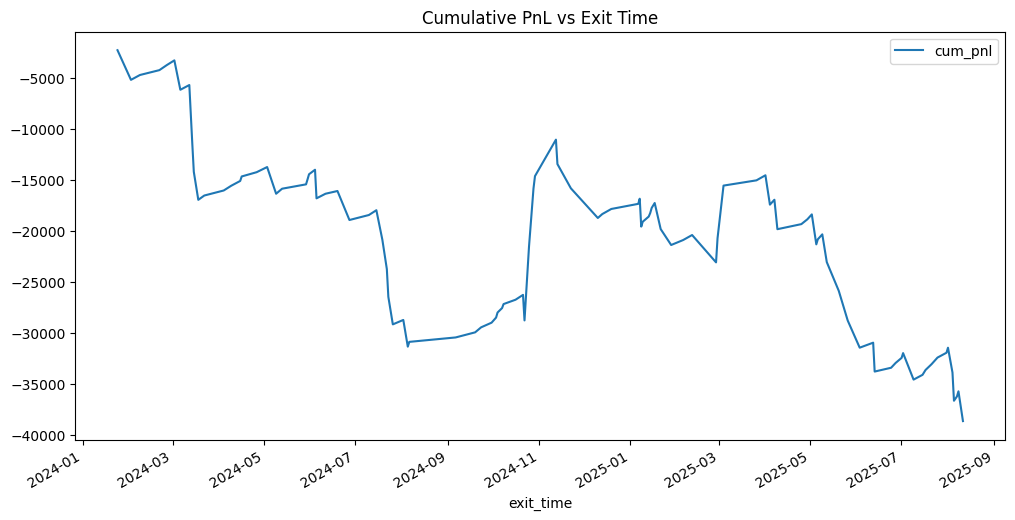

In [25]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))

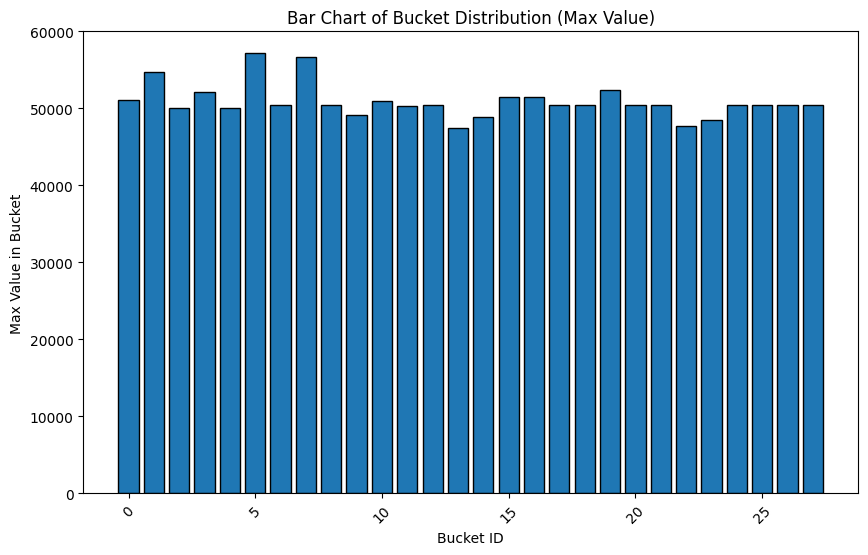

In [26]:
snapdf = pd.DataFrame(pd.DataFrame(bank.snapshot).max(), columns=['max'])
bucdf = pd.DataFrame(bank.bucket_usage_count, index=[0]).T
bucket_distribution = pd.concat([snapdf, bucdf], axis=1).rename(columns={0: 'usage_count'}).reset_index().rename(columns={'index': 'bucket_id'})

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(bucket_distribution['bucket_id'])), bucket_distribution['max'], edgecolor='black')
plt.title('Bar Chart of Bucket Distribution (Max Value)')
plt.xlabel('Bucket ID')
plt.ylabel('Max Value in Bucket')
plt.xticks(rotation=45)
plt.show()

In [27]:
signals.Date.unique().shape

(100,)

In [28]:
trades

,stock,entry_time,avg_entry_price,last_entry_price,quantity,exit_time,exit_price,tp,sl,trades,pnl,tax,leverage,mtf_rate_daily,tp_perc,sl_perc,max_mtf_days,cum_pnl
0,NSE:PAGEIND-EQ,2024-01-16 05:30:00+05:30,38743.6560,38743.6560,1,2024-01-24 05:30:00+05:30,36486.744000,39960.206798,36486.744000,"[{'capital_key': '3d76b366', 'entry_time': 202...",-2256.912000,15.382435,1,0.000192,3.14,100,100,-2256.912000
1,NSE:ASHOKLEY-EQ,2024-02-05 05:30:00+05:30,89.6409,89.6409,557,2024-02-02 05:30:00+05:30,84.419100,92.455624,84.419100,"[{'capital_key': '3d76b474', 'entry_time': 202...",-2908.542600,19.823754,1,0.000192,3.14,100,100,-5165.454600
2,NSE:M&MFIN-EQ,2024-01-31 05:30:00+05:30,280.1600,280.1600,170,2024-02-08 05:30:00+05:30,282.961600,288.957024,282.961600,"[{'capital_key': '3d76b366', 'entry_time': 202...",476.272000,19.130511,1,0.000192,3.14,100,100,-4689.182600
3,NSE:ASTRAL-EQ,2024-02-12 05:30:00+05:30,1908.0235,1908.0235,25,2024-02-21 05:30:00+05:30,1927.103735,1967.935438,1927.103735,"[{'capital_key': '3d76b366', 'entry_time': 202...",477.005875,19.159988,1,0.000192,3.14,100,100,-4212.176725
4,NSE:M&MFIN-EQ,2024-02-16 05:30:00+05:30,287.0713,287.0713,174,2024-02-26 05:30:00+05:30,289.942013,296.085339,289.942013,"[{'capital_key': '3d76b488', 'entry_time': 202...",499.504062,20.063678,1,0.000192,3.14,100,100,-3712.672663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NSE:APOLLOTYRE-EQ,2025-07-17 05:30:00+05:30,468.8560,468.8560,89,2025-08-04 05:30:00+05:30,441.544000,483.578078,441.544000,"[{'capital_key': '3daa322c', 'entry_time': 202...",-2430.768000,16.567385,1,0.000192,3.14,100,100,-33858.564428
102,NSE:DRREDDY-EQ,2025-07-24 05:30:00+05:30,1284.8220,1284.8220,37,2025-08-05 05:30:00+05:30,1209.978000,1325.165411,1209.978000,"[{'capital_key': '3e00931a', 'entry_time': 202...",-2769.228000,18.874227,1,0.000192,3.14,100,100,-36627.792428
103,NSE:APOLLOHOSP-EQ,2025-06-02 05:30:00+05:30,7086.9150,7086.9150,6,2025-08-07 05:30:00+05:30,7157.784150,7309.444131,7157.784150,"[{'capital_key': '3e016d30', 'entry_time': 202...",425.214900,17.079690,1,0.000192,3.14,100,100,-36202.577528
104,NSE:BIOCON-EQ,2025-06-11 05:30:00+05:30,351.4360,351.4360,142,2025-08-08 05:30:00+05:30,354.950360,362.471090,354.950360,"[{'capital_key': '3e0cae16', 'entry_time': 202...",499.039120,20.045002,1,0.000192,3.14,100,100,-35703.538408
